In [1]:
from numba import jit
import numpy as np

@jit(nogil=True, fastmath=True)
def create_polygon_jit(points, n, target_n, gridsize, search_range, curr_area, reached_max_i, val_max_j, reached_min_j, min_area, soln):
    if n >= 3:
        #Solution found
        if n == target_n:
            min_area[0] = curr_area
            soln[:] = points.copy()
            return True
        
        #Stage variables
        reached_max_i = reached_max_i or (points[n-1][0] == gridsize - 1)
        if val_max_j < 0:
            if points[n-2][1] > points[n-1][1]:
                val_max_j = points[n-2][1]
        reached_min_j = reached_min_j or (reached_max_i and (points[n-2][1] < points[n-1][1]))

    if not reached_max_i:
        #stage 1,2 i (only move ahead)
        min_i = points[n-1][0]
        max_i = min(gridsize, points[n-1][0] + search_range + 1)
        if val_max_j < 0:
            #stage 1 j (can't do anything)
            min_j = max(-gridsize, points[n-1][1] - search_range)
            max_j = min(gridsize, points[n-1][1] + search_range + 1)
        else:
            #stage 2 j (only move down)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = points[n-1][1] + 1
    else:
        #stage 3,4 i (only move back)
        min_i = max(1, points[n-1][0] - search_range)
        max_i = points[n-1][0] + 1
        if not reached_min_j:
            #stage 3 j (can't do anything)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = min(val_max_j, points[n-1][1] + search_range + 1)
        else:
            #stage 4 j (only move up)
            min_j = points[n-1][1]
            max_j = min(0, points[n-1][1] + search_range + 1)

    
    if n>=2:
        x1, y1 = points[n-2][0]-points[n-1][0], points[n-2][1]-points[n-1][1]
        
    for i in range(min_i, max_i):
        min_j_use = min_j
        max_j_use = max_j
        if n>=2:
            x2 = i-points[n-1][0]
            if x1 > 0: #< 180 degree convex
                min_j_use = max(min_j, points[n-1][1]+((x2*y1)//x1))
            elif x1 < 0: #< 180 degree convex
                max_j_use = min(max_j_use, points[n-1][1]-((x2*y1)//x1))
            if points[n-1][0] > 0: # 0,0 area
                max_j_use = min(max_j,1+(i*points[n-1][1])//points[n-1][0])
        for j in range(min_j_use, max_j_use):
            if n>=2:
                y2 = j-points[n-1][1]
                if x1*y2-x2*y1<=0:#< 180 degree convex
                    continue
                if i != gridsize - 1:#acute only at ends
                    if x1*x2+y1*y2>0:
                        continue
                    if x1*y2-x2*y1>2:#almost 180 degree
                        continue
                add_area = i*points[n-1][1]-j*points[n-1][0] # 0,0 area
                if add_area <= 0:
                    continue
                if curr_area + add_area>= min_area[0]:
                    continue
            points[n][0], points[n][1] = i, j
            result = create_polygon_jit(points, n+1, target_n, gridsize, search_range, curr_area+add_area, reached_max_i, val_max_j, reached_min_j, min_area, soln)
    points[n][0], points[n][1] = 0,0 #not needed, but nice
    return True

In [2]:
for gridsize in range(30,40):
    import time
    n = 19
    points = np.array([(0,0)]*n) #List([(0,0)]*n)
    results = []
    soln = points.copy()
    doublearea = np.array([2*gridsize**2])
    start = time.perf_counter()
    _ = create_polygon_jit(points, 1, n, gridsize, 11, 0, False, -1, False, doublearea, soln)
    print(round(time.perf_counter()-start, 2), "seconds,", doublearea[0], "area")
    if doublearea[0] == 213:
        shape = soln.tolist()
    print("points:", soln.tolist())

11.44 seconds, 215 area
points: [[0, 0], [0, 1], [1, 1], [3, 0], [6, -2], [13, -7], [17, -10], [22, -14], [28, -19], [29, -20], [29, -21], [28, -21], [26, -20], [21, -17], [18, -15], [11, -10], [7, -7], [2, -3], [1, -2]]
12.12 seconds, 225 area
points: [[0, 0], [0, 1], [1, 1], [3, 0], [10, -4], [13, -6], [20, -11], [24, -14], [29, -18], [30, -19], [30, -20], [29, -20], [26, -19], [24, -18], [19, -15], [16, -13], [12, -10], [7, -6], [1, -1]]
8.16 seconds, 213 area
points: [[0, 0], [0, 1], [1, 1], [3, 0], [8, -3], [16, -8], [19, -10], [26, -15], [30, -18], [31, -19], [31, -20], [30, -20], [27, -19], [25, -18], [20, -15], [17, -13], [10, -8], [6, -5], [1, -1]]
10.99 seconds, 225 area
points: [[0, 0], [1, 0], [4, -1], [6, -2], [11, -5], [19, -10], [22, -12], [26, -15], [31, -19], [32, -20], [32, -21], [31, -21], [28, -20], [26, -19], [21, -16], [18, -14], [11, -9], [7, -6], [1, -1]]
10.0 seconds, 225 area
points: [[0, 0], [0, 1], [1, 1], [3, 0], [12, -5], [17, -8], [25, -13], [28, -15], [3

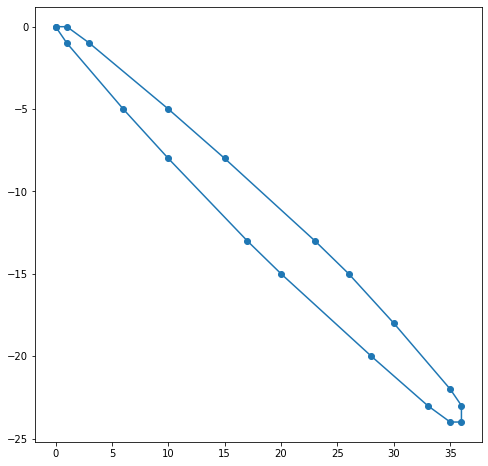

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*shape)
i = list(i) + [i[0]]
j = list(j) + [j[0]]
plt.plot(i,j)
plt.scatter(i,j)
plt.show()